# Анализ и выделение признаков - лабораторная работа

## ИУ5 ОАД

### Цель:
Научиться анализировать данные и выделять из них полезные признаки, научиться пользоваться `seaborn` и `sklearn`, познакомиться с основными понятиями Data Science.

**Обратите внимание**, что в каждом разделе лабораторной работы есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — отсутствие ответов приравнивается к невыполненной лабораторной работе. Ответы без кода – аналогично.

In [ ]:
#!pip install pandas matplotlib seaborn

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train = pd.read_csv('train.csv')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку для обучения модели машинного обучения нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
# train = train.drop('dropoff_datetime', axis=1)
# train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

**Вопрос**: Почему нельзя использовать `dropoff_datetime` для обучения модели машинного обучения? Какие есть противоречия?

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

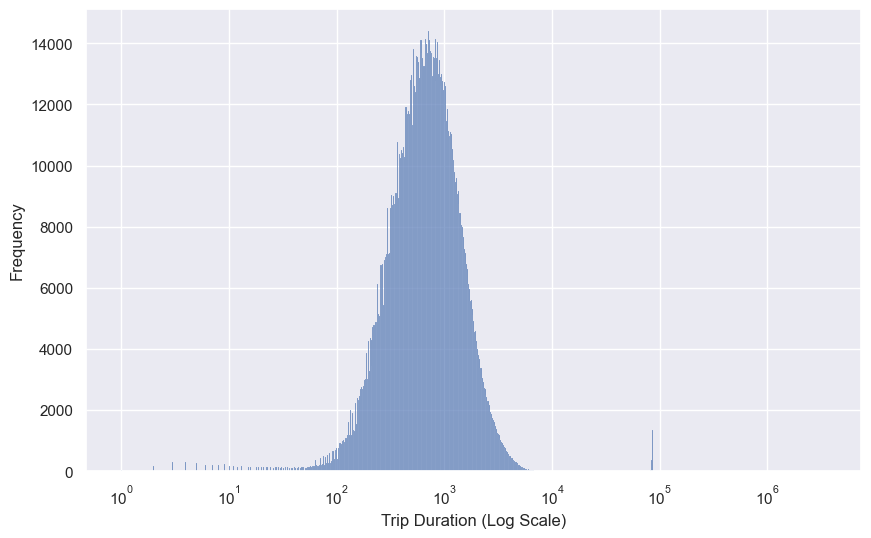

In [5]:
plt.figure(figsize=(10, 6))  
sns.histplot(train['trip_duration'], log_scale=True) 
plt.xlabel('Trip Duration (Log Scale)')
plt.ylabel('Frequency')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

## Часть 1. Изучаем `pickup_datetime`

**Задание 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

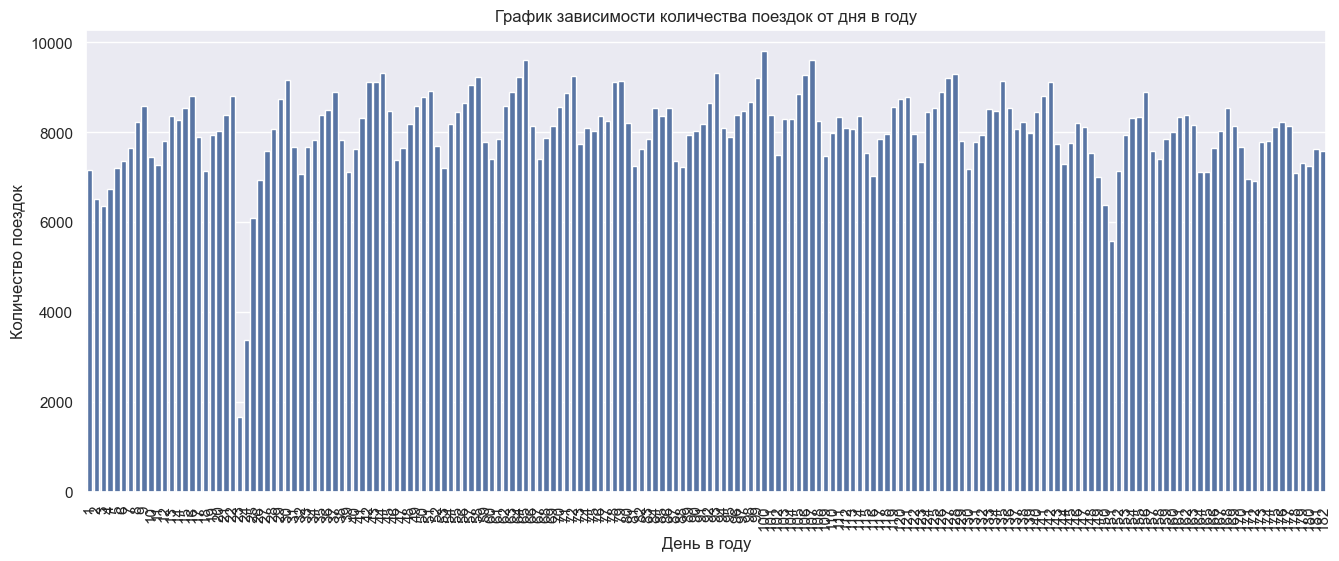

In [20]:
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(16, 6))
sns.countplot(x='day_of_year', data=train)
plt.title('График зависимости количества поездок от дня в году')
plt.xlabel('День в году')
plt.ylabel('Количество поездок')
plt.xticks(rotation=90)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [15]:
low_trip_days = train.groupby('day_of_year')['id'].count().nsmallest(2).index

low_trip_dates = []
for day_of_year in low_trip_days:
    try:
        date = pd.to_datetime(str(day_of_year), format='%j')  # Преобразование в строку
        low_trip_dates.append(date.strftime('%Y-%m-%d'))
    except ValueError as e:
        print(f"Ошибка преобразования дня года {day_of_year}: {e}")
        low_trip_dates.append(None)  # Или другое значение по умолчанию

print(f"Dates with unusually low trip counts: {low_trip_dates}")

Dates with unusually low trip counts: ['1900-01-23', '1900-01-24']


**Задание 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

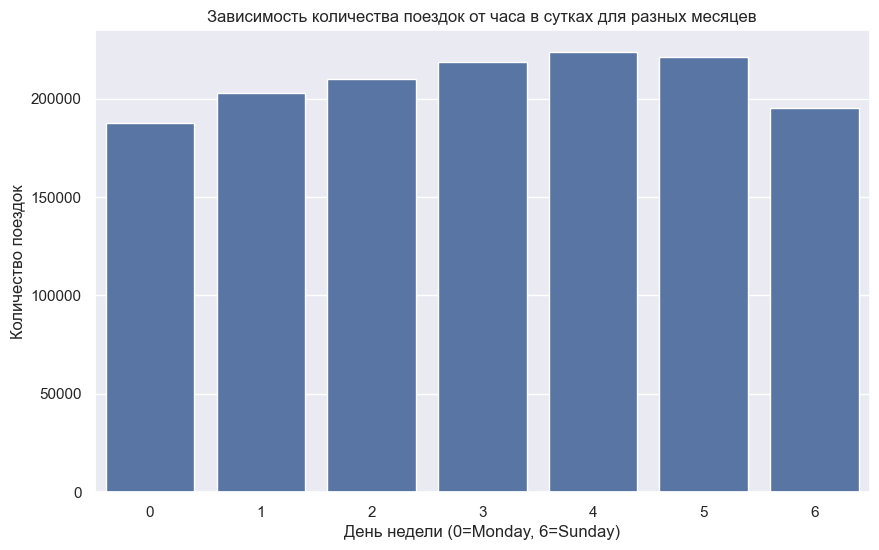

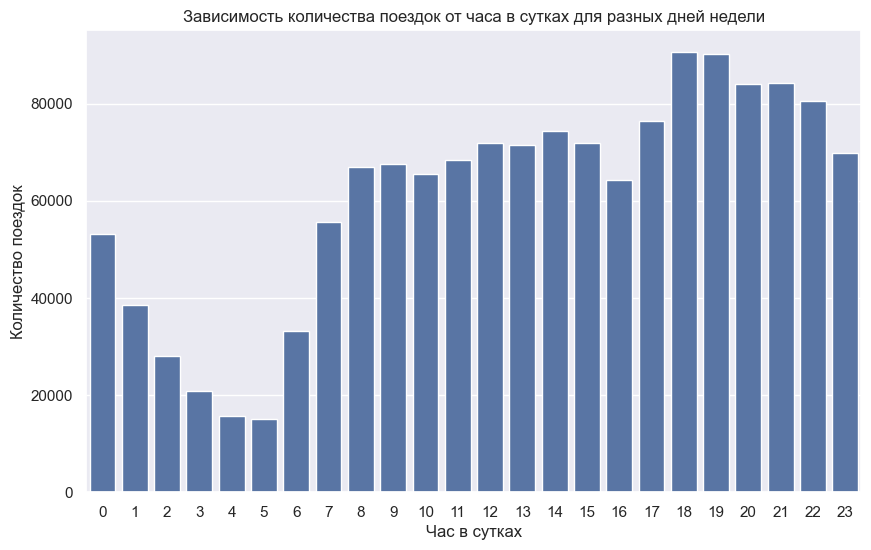

In [21]:
# зависимости количества поездок от часа в сутках для разных месяцев
plt.figure(figsize=(10, 6))
sns.countplot(x=train['pickup_datetime'].dt.dayofweek, data=train)
plt.title('Зависимость количества поездок от часа в сутках для разных месяцев')
plt.xlabel('День недели (0=Monday, 6=Sunday)')
plt.ylabel('Количество поездок')
plt.show()

# зависимости количества поездок от часа в сутках для разных дней недели
plt.figure(figsize=(10, 6))
sns.countplot(x=train['pickup_datetime'].dt.hour, data=train)
plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4**. Разбейте выборку на обучающую и тестовую в отношении 7:3, представьте, что вы готовите данные для обучения модели машинного обучения (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

<Figure size 1600x800 with 0 Axes>

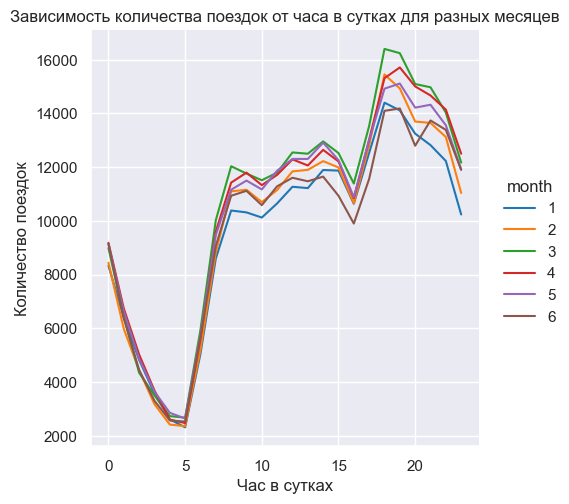

<Figure size 1600x800 with 0 Axes>

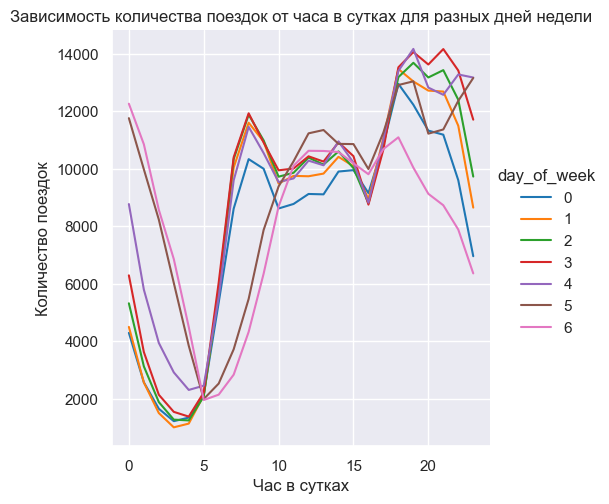

In [22]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['hour'] = train['pickup_datetime'].dt.hour
train['month'] = train['pickup_datetime'].dt.month
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek

# Считаем количество поездок по часам для каждого месяца
hourly_data_by_month = train.groupby(['hour', 'month']).size().reset_index(name='trip_count')

# Считаем количество поездок по часам для каждого дня недели
hourly_data_by_day = train.groupby(['hour', 'day_of_week']).size().reset_index(name='trip_count')

# Построение графика зависимости количества поездок от часа в сутках для разных месяцев
plt.figure(figsize=(16, 8))
sns.relplot(
    x='hour',
    y='trip_count',
    hue='month',
    kind='line',
    data=hourly_data_by_month,
    palette="tab10"
)
plt.title('Зависимость количества поездок от часа в сутках для разных месяцев')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.show()

# Построение графика зависимости количества поездок от часа в сутках для разных дней недели
plt.figure(figsize=(16, 8))
sns.relplot(
    x='hour',
    y='trip_count',
    hue='day_of_week',
    kind='line',
    data=hourly_data_by_day,
    palette="tab10"
)
plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [28]:
# Add day of the week
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek

# Add month
train['month'] = train['pickup_datetime'].dt.month

# Add hour
train['hour'] = train['pickup_datetime'].dt.hour

# Add day of the year
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [23]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [25]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [5]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

NameError: name 'show_circles_on_map' is not defined

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 5**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [30]:
def haversine(lat1, lon1, lat2, lon2):
    # Радиус Земли в километрах
    R = 6371.0

    # Преобразуем широты и долготы из градусов в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Разницы в координатах
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Формула Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Расстояние
    distance = R * c
    return distance

train_copy = train.copy()
train_copy['haversine'] = haversine(train_copy['pickup_latitude'],
                                     train_copy['pickup_longitude'],
                                     train_copy['dropoff_latitude'],
                                     train_copy['dropoff_longitude'])

Так как мы можем предсказывать логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [32]:
train_copy['log_haversine'] = np.log1p(train_copy['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [34]:
your_df = train_copy 
train_copy['log_trip_duration'] = np.log1p(train_copy['trip_duration'])
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 6**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

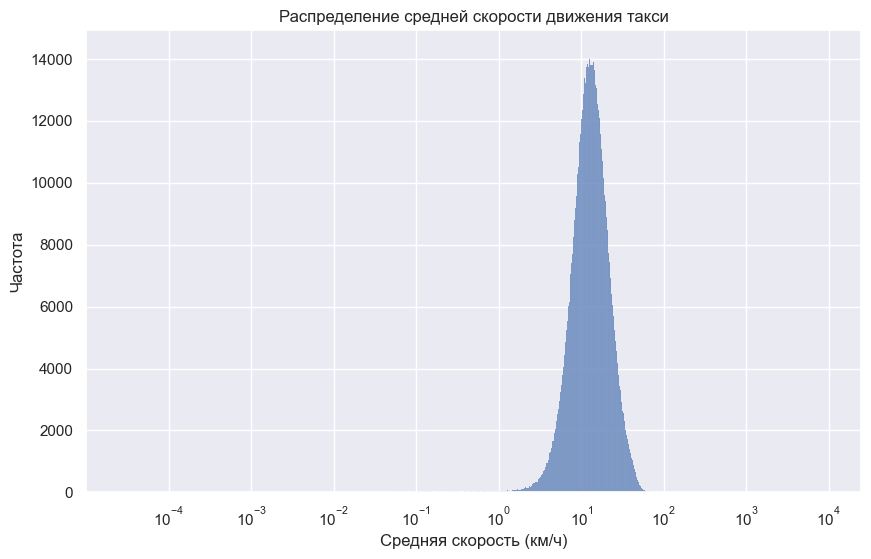

In [38]:
train_copy['avg_speed'] = train_copy['haversine'] * 3600 / train_copy['trip_duration']

plt.figure(figsize=(10, 6))
sns.histplot(train_copy['avg_speed'], log_scale=True)
plt.title('Распределение средней скорости движения такси')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

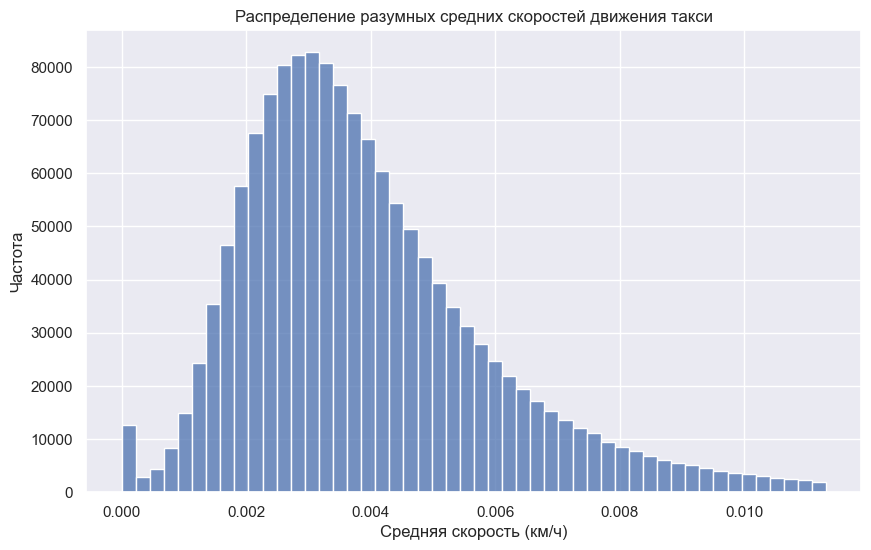

In [40]:
train_copy['avg_speed'] = train_copy['haversine'] / train_copy['trip_duration']
speed_threshold = train_copy['avg_speed'].quantile(0.99)

filtered_train_copy = train_copy[train_copy['avg_speed'] <= speed_threshold]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_train_copy['avg_speed'], bins=50)
plt.title('Распределение разумных средних скоростей движения такси')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Частота')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

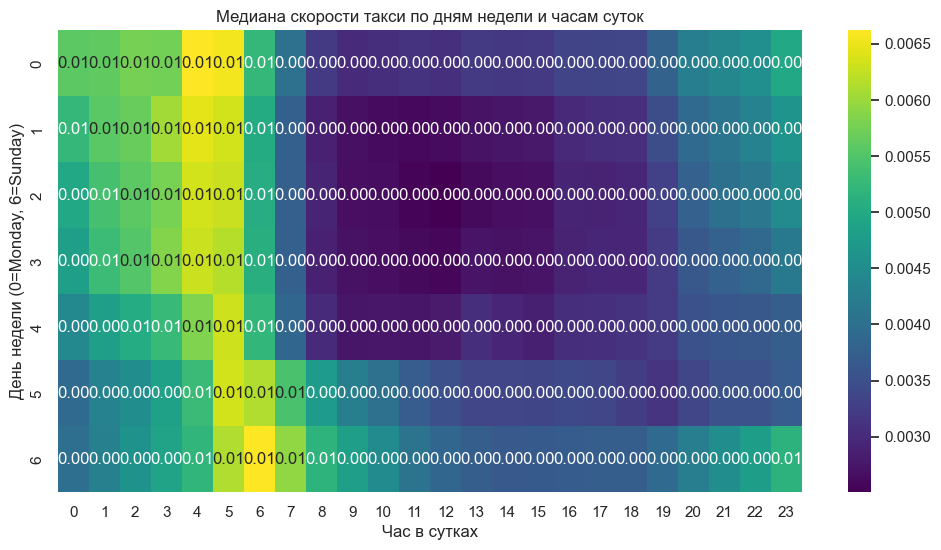

In [41]:
train_copy['avg_speed'] = train_copy['haversine'] / train_copy['trip_duration']
median_speeds = train_copy.groupby([train_copy['pickup_datetime'].dt.dayofweek,
                                  train_copy['pickup_datetime'].dt.hour])['avg_speed'].median().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(median_speeds, cmap='viridis', annot=True, fmt=".2f")
plt.title('Медиана скорости такси по дням недели и часам суток')
plt.xlabel('Час в сутках')
plt.ylabel('День недели (0=Monday, 6=Sunday)')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения? - 
Значение скорости поездки (скорость в км/ч, miles/hour и т.д.) нельзя напрямую использовать во время обучения модели предсказания длительности поездки в соревновании New York City Taxi Trip Duration из-за нескольких причин:

Скорость вычисляется после поездки: Скорость — это производная величина. Для ее вычисления необходимо знать как начальную, так и конечную точку поездки, а также затраченное время. Но модель должна предсказывать длительность поездки до того, как поездка завершится, и, следовательно, скорость неизвестна в момент предсказания. Использовать скорость в качестве входного признака равносильно “подглядыванию в будущее”.

Скорость может быть нерепрезентативной: Средняя скорость поездки может сильно варьироваться из-за различных факторов, таких как дорожные условия, пробки, стиль вождения водителя, количество остановок и т.д. Средняя скорость, вычисленная по всему маршруту, может не отражать реальную скорость в разные моменты поездки.

Скорость может быть искажена: В данных могут быть ошибки или неточности в данных о местоположении или времени, что приведет к неточным значениям скорости, что, в свою очередь, может привести к ошибочным предсказаниям модели.

Скорость сама зависит от длительности поездки: Длительность поездки и средняя скорость — взаимозависимые величины. Если модель будет использовать скорость как признак, она будет моделировать корреляцию, а не причинно-следственную связь.

Проблема с нулевой скоростью: Нулевая скорость может возникать из-за остановки, но это не всегда означает завершение поездки. Исключение нулевых значений скорости приводит к потере данных.

In [42]:
train_copy = train_copy.drop('avg_speed', axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [44]:
# ВАШ КОД ТУТ

**Задание 7**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [ ]:
# ВАШ КОД ТУТ

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [ ]:
# ВАШ КОД ТУТ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 8**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ...):
        # your code here
        pass
    
    def show_map(self):
        # you may want to visualize cells
        pass
    
    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
        # your code here
        return X

## Часть 3. Изучаем оставшиеся признаки

**Задание 9**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [45]:
unique_values = {
    'vendor_id': train_copy['vendor_id'].nunique(),
    'passenger_count': train_copy['passenger_count'].nunique(),
    'store_and_fwd_flag': train_copy['store_and_fwd_flag'].nunique()
}

print(unique_values)

{'vendor_id': 2, 'passenger_count': 10, 'store_and_fwd_flag': 2}


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

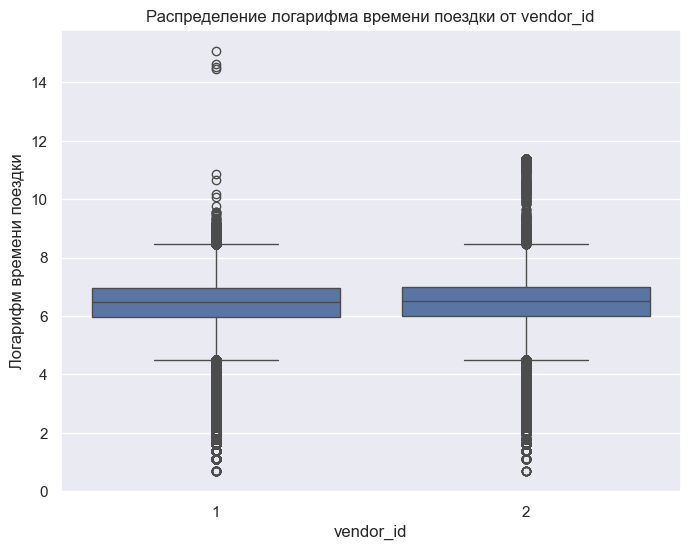

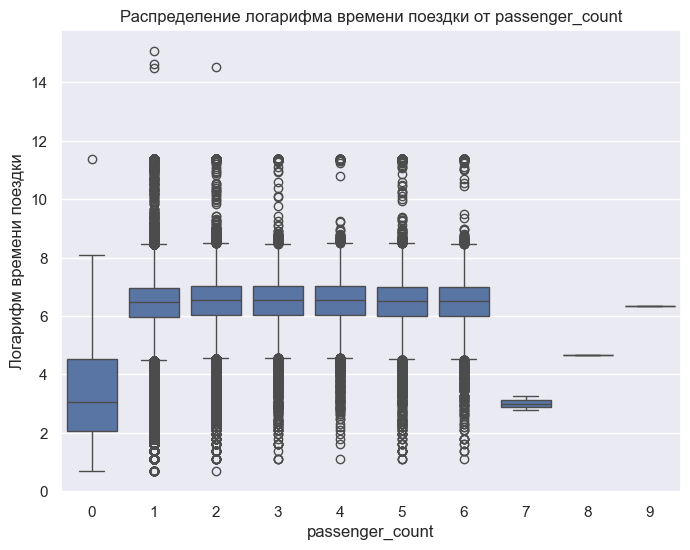

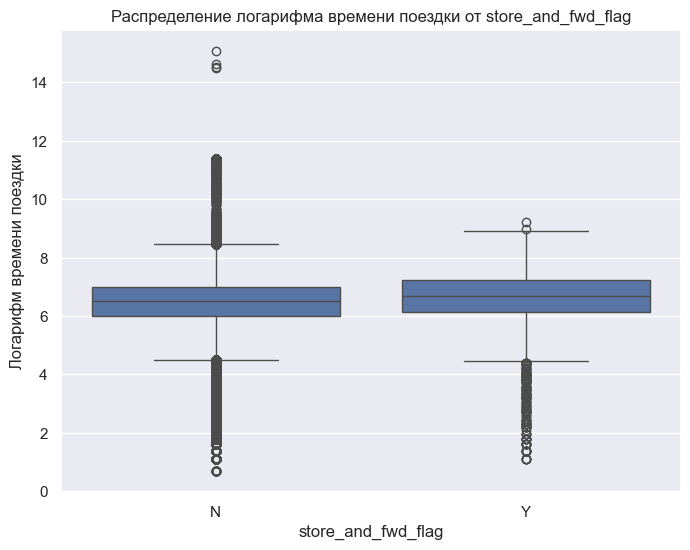

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

train_copy['log_trip_duration'] = np.log1p(train_copy['trip_duration'])
features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

for feature in features:
    plt.figure(figsize=(8, 6))  
    sns.boxplot(x=feature, y='log_trip_duration', data=train_copy)
    plt.title(f'Распределение логарифма времени поездки от {feature}')
    plt.xlabel(feature)
    plt.ylabel('Логарифм времени поездки')
    plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [48]:
train_copy['vendor_id'] = train_copy['vendor_id'].map({1: 0, 2: 1})
train_copy['store_and_fwd_flag'] = train_copy['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

## Часть 4. Улучшаем данные

**Задание 10**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

In [53]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Определим категориальные признаки
categorical_features = ['vendor_id', 'store_and_fwd_flag', 'passenger_count',
                          'day_of_week', 'month', 'hour']

# Установим пороговое значение для редких категорий (например, 5%).
rare_threshold = 0.05

# Обработаем каждый категориальный признак
for feature in categorical_features:
    # Рассчитаем частоту встречаемости категорий
    category_frequencies = train_copy[feature].value_counts(normalize=True)
    # Определеним редкие категории
    rare_categories = category_frequencies[category_frequencies < rare_threshold].index
    # Заменим редкие категории на "редкие"
    train_copy[feature] = train_copy[feature].astype(str)
    train_copy.loc[train_copy[feature].isin(rare_categories), feature] = 'rare'
    train_copy.loc[train_copy[feature].isin(rare_categories), feature] = 'rare'

**Задание 11**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [58]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Количество признаков до кодирования
num_features_before = len(train_copy.columns)

# One-hot кодирование
categorical_features = ['vendor_id', 'store_and_fwd_flag', 'passenger_count',
                         'day_of_week', 'month', 'hour']

# Создадим кодировщик
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output
encoded_data = encoder.fit_transform(train_copy[categorical_features])  # Fit on training data only

# Количество признаков после кодирования
num_features_after = num_features_before - len(categorical_features) + encoded_data.shape[1]

# Вывод результатов
print(f"Количество признаков до кодирования: {num_features_before}")
print(f"Количество признаков после кодирования: {num_features_after}")

Количество признаков до кодирования: 17
Количество признаков после кодирования: 40


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 12**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут.

**Вопрос**: Почему такой признак потенциально полезный? 

In [ ]:
# ВАШ КОД ТУТ

**Задание 13 (бонус)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси.

In [ ]:
# ВАШ КОД ТУТ

**Задание 14 **. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

In [8]:
# ВАШ КОД ТУТ